In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from pycytominer.cyto_utils import infer_cp_features
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, "../../scripts")
from utils import load_data
from scipy.stats import pearsonr, ttest_ind, ttest_1samp

import seaborn
from sklearn.decomposition import PCA
import random

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubun

In [2]:
np.random.seed(82)
NUM_RANDOM_SAMPLES = 1000

In [3]:
data_dict = load_data(["complete"])
meta_features = infer_cp_features(data_dict["complete"], metadata=True)
cp_features = infer_cp_features(data_dict["complete"])

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")

In [4]:
latent_df = pd.read_csv("latent.csv").drop("Unnamed: 0", axis = 1)
pca = PCA(n_components=5)
pca_latent_df = pd.DataFrame(pca.fit_transform(complete_features_df), columns = ['0','1','2','3','4'])

In [5]:
moa_df = pd.read_csv("repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=complete_meta_df['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
meta_moa_latent_df = pd.concat([complete_meta_df,moa_df,latent_df], axis=1)
meta_moa_pca_latent_df = pd.concat([complete_meta_df,moa_df,pca_latent_df], axis=1)
meta_moa_complete_df = pd.concat([complete_meta_df,moa_df,complete_features_df], axis=1)

# fill negative control DMSO profiles, change the NaN MOA label to be DMSO
meta_moa_latent_df.loc[meta_moa_latent_df['Metadata_broad_sample'] == 'DMSO', 'moa'] = 'DMSO'
meta_moa_pca_latent_df.loc[meta_moa_pca_latent_df['Metadata_broad_sample'] == 'DMSO', 'moa'] = 'DMSO'
meta_moa_complete_df.loc[meta_moa_complete_df['Metadata_broad_sample'] == 'DMSO', 'moa'] = 'DMSO'

#drop profiles with NaN MOAs
meta_moa_latent_df = meta_moa_latent_df.dropna(subset=['moa']).reset_index(drop = True)
meta_moa_pca_latent_df = meta_moa_pca_latent_df.dropna(subset=['moa']).reset_index(drop = True)
meta_moa_complete_df = meta_moa_complete_df.dropna(subset=['moa']).reset_index(drop = True)

# add columns to the dataframe that are randomnly shuffled permutations of the MOA column
for i in range(NUM_RANDOM_SAMPLES):
    random_moa_labels = pd.DataFrame([meta_moa_latent_df.moa.sample(frac=1)]).transpose().reset_index().drop('index', axis = 1)
    random_moa_labels = random_moa_labels.rename(columns={'moa': 'random_moa_labels' + str(i)})

    meta_moa_latent_df = pd.concat([random_moa_labels, meta_moa_latent_df], axis=1)
    meta_moa_pca_latent_df = pd.concat([random_moa_labels, meta_moa_pca_latent_df], axis=1)

    meta_moa_complete_df = pd.concat([random_moa_labels, meta_moa_complete_df], axis=1)

meta_moa_complete_df.head()

,random_moa_labels999,random_moa_labels998,random_moa_labels997,random_moa_labels996,random_moa_labels995,random_moa_labels994,random_moa_labels993,random_moa_labels992,random_moa_labels991,random_moa_labels990,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,AMPK activator,dopamine receptor agonist,GK0582 inhibitor,dihydrofolate reductase inhibitor,dopamine receptor antagonist,calpain inhibitor|cysteine protease inhibitor,sodium/glucose cotransporter inhibitor,cholinergic receptor agonist,dopamine receptor antagonist,CDK inhibitor,...,0.164260,0.22701,0.20854,0.22897,0.53738,0.43547,0.41635,0.28933,0.34017,0.31368
1,MEK inhibitor,bacterial cell wall synthesis inhibitor,anticancer agent,renin inhibitor,JAK inhibitor,MEK inhibitor,DMSO,beta-secretase inhibitor,acetylcholine receptor agonist|benzodiazepine ...,acetylcholine receptor antagonist,...,0.184110,0.23932,0.21854,0.24763,0.56995,0.47084,0.37764,0.32148,0.36964,0.34328
2,DMSO,DMSO,retinoid receptor agonist,gluconeogenesis inhibitor,calcium channel blocker,topoisomerase inhibitor,DeltaF508-CFTR Correctors,adrenergic receptor agonist,DMSO,bacterial 30S ribosomal subunit inhibitor|bact...,...,0.175640,0.23366,0.21743,0.23448,0.56980,0.47254,0.39575,0.31969,0.36626,0.34086
3,DMSO,retinoid receptor agonist,histamine receptor antagonist,DMSO,mineralocorticoid receptor antagonist,thymidylate synthase inhibitor,topoisomerase inhibitor,dopamine receptor antagonist|serotonin recepto...,HMGCR inhibitor,HCN channel blocker|potassium channel blocker|...,...,0.141310,0.18764,0.17342,0.18641,0.54696,0.44890,0.40042,0.30187,0.35082,0.32103
4,pyruvate dehydrogenase kinase inhibitor,breast cancer resistance protein inhibitor,cyclooxygenase inhibitor|platelet aggregation ...,angiotensin antagonist,proteasome inhibitor,xanthine oxidase inhibitor,immunosuppressant|sphingosine 1-phosphate rece...,AKT inhibitor,DMSO,xanthine oxidase inhibitor,...,0.094635,0.16631,0.15218,0.15540,0.56882,0.46601,0.40149,0.31658,0.36167,0.33338


In [6]:
meta_moa_latent_df.columns

Index(['random_moa_labels999', 'random_moa_labels998', 'random_moa_labels997',
       'random_moa_labels996', 'random_moa_labels995', 'random_moa_labels994',
       'random_moa_labels993', 'random_moa_labels992', 'random_moa_labels991',
       'random_moa_labels990',
       ...
       'target', 'broad_date', 'clinical_phase', 'alternative_moa',
       'alternative_target', '0', '1', '2', '3', '4'],
      dtype='object', length=1020)

In [7]:
moas_occurrence = pd.read_csv("moas_occurrence.tsv", sep = "\t")
moas_occurrence.index = moas_occurrence['moa']
moas_occurrence = moas_occurrence.drop('moa', axis = 1)

#We only want moa combinations with enough data, so we pick A|B such that there are at least 5 A|B, 5 A, and 5 B.
valid_pipes = moas_occurrence[((moas_occurrence != 0).all(axis = 1)) & (moas_occurrence['full moa occurrence'] > 5) & (moas_occurrence['moa1 occurrence'] > 5)& (moas_occurrence['moa2 occurrence'] > 5)].index
valid_pipes = valid_pipes[valid_pipes.str.count("\|") == 1]

In [8]:
def subset_by_moa(pipe, df_name, column):
    moas = pipe.split("|")
    subset_df = pd.concat([df_name[df_name[column] == moas[0]],df_name[df_name[column] == moas[1]]])
    return subset_df

def LSA(A, B, D):
    return A-D+B

In [9]:
#calculate means for each A and B in each A|B.
subset_means = []
subset_random_means = []
subset_pca_means = []
subset_pca_random_means = []

for pipe in valid_pipes:
    subset = subset_by_moa(pipe, meta_moa_latent_df, 'moa')
    subset_mean = subset.groupby(['moa'])[['0','1','2','3','4']].mean()
    subset_pca = subset_by_moa(pipe, meta_moa_pca_latent_df, 'moa')
    subset_pca_mean = subset_pca.groupby(['moa'])[['0','1','2','3','4']].mean()
    
    
    subsets_random_mean = []
    subsets_pca_random_mean = []
    for i in range(NUM_RANDOM_SAMPLES):
        label = 'random_moa_labels' + str(i)
        subset_random = subset_by_moa(pipe, meta_moa_latent_df, label)
        subset_random_mean = subset_random.groupby([label])[['0','1','2','3','4']].mean()
        subsets_random_mean.append(subset_random_mean)
        
        subset_pca_random = subset_by_moa(pipe, meta_moa_pca_latent_df, label)
        subset_pca_random_mean = subset_pca_random.groupby([label])[['0','1','2','3','4']].mean()
        subsets_pca_random_mean.append(subset_pca_random_mean)
    
    subset_means.append(subset_mean)
    subset_pca_means.append(subset_pca_mean)
    subset_random_means.append(subsets_random_mean)
    subset_pca_random_means.append(subsets_pca_random_mean)
    


In [10]:
#calculate means for DMSO
DMSO = meta_moa_latent_df[meta_moa_latent_df.moa == 'DMSO']
DMSO_pca = meta_moa_pca_latent_df[meta_moa_pca_latent_df.moa == 'DMSO']
DMSO_means = np.mean(DMSO[['0','1','2','3','4']])
DMSO_means_pca = np.mean(DMSO_pca[['0','1','2','3','4']])

DMSO_means_random = []
DMSO_means_pca_random = []
for i in range(NUM_RANDOM_SAMPLES):
    label = 'random_moa_labels' + str(i)
    DMSO_random = meta_moa_latent_df[meta_moa_latent_df[label] == 'DMSO']
    DMSO_means_random.append(np.mean(DMSO_random[['0','1','2','3','4']]))

    DMSO_pca_random = meta_moa_pca_latent_df[meta_moa_pca_latent_df[label] == 'DMSO']
    DMSO_means_pca_random.append(np.mean(DMSO_pca_random[['0','1','2','3','4']]))





In [11]:
#perform latent space arithmetic
representations_after_LSA = []
representations_after_LSA_random = []
representations_after_LSA_pca = []
representations_after_LSA_pca_random = []


for i in range(len(subset_means)):
    representation_after_LSA = LSA(subset_means[i].loc[valid_pipes[i].split("|")[0]],subset_means[i].loc[valid_pipes[i].split("|")[1]],DMSO_means)
    representation_after_LSA = pd.DataFrame(representation_after_LSA).transpose()
    representations_after_LSA.append(representation_after_LSA)
    
    representation_after_LSA_pca = LSA(subset_pca_means[i].loc[valid_pipes[i].split("|")[0]],subset_pca_means[i].loc[valid_pipes[i].split("|")[1]],DMSO_means_pca)
    representation_after_LSA_pca = pd.DataFrame(representation_after_LSA_pca).transpose()
    representations_after_LSA_pca.append(representation_after_LSA_pca)
    
    LSA_random_1pipe = []
    PCA_random_1pipe = []
    for j in range(NUM_RANDOM_SAMPLES):
        representation_after_LSA_random = LSA(subset_random_means[i][j].loc[valid_pipes[i].split("|")[0]],subset_random_means[i][j].loc[valid_pipes[i].split("|")[1]],DMSO_means_random[j])
        representation_after_LSA_random = pd.DataFrame(representation_after_LSA_random).transpose()
        LSA_random_1pipe.append(representation_after_LSA_random)    

        representation_after_LSA_pca_random = LSA(subset_pca_random_means[i][j].loc[valid_pipes[i].split("|")[0]],subset_pca_random_means[i][j].loc[valid_pipes[i].split("|")[1]],DMSO_means_pca_random[j])
        representation_after_LSA_pca_random = pd.DataFrame(representation_after_LSA_pca_random).transpose()
        PCA_random_1pipe.append(representation_after_LSA_pca_random)
        
    representations_after_LSA_random.append(LSA_random_1pipe)
    representations_after_LSA_pca_random.append(PCA_random_1pipe)

In [12]:
#decode each latent space representation
decoder = keras.models.load_model("../2.train/decoder")
reconstruction = pd.concat([moa_df,random_moa_labels,pd.DataFrame(decoder.predict(latent_df), columns = cp_features)], axis = 1)
predictions = []
predictions_random = []
predictions_pca = []
predictions_pca_random = []

for i in range(len(representations_after_LSA)):
    predictions.append(decoder.predict(representations_after_LSA[i]))
    predictions_pca.append(pca.inverse_transform(representations_after_LSA_pca[i]))
    
    predictions_random_1pipe = []
    predictions_pca_random_1pipe = []
    for j in range(NUM_RANDOM_SAMPLES):
        predictions_random_1pipe.append(decoder.predict(representations_after_LSA_random[i][j]))
        predictions_pca_random_1pipe.append(pca.inverse_transform(representations_after_LSA_pca_random[i][j]))

    predictions_random.append(predictions_random_1pipe)
    predictions_pca_random.append(predictions_pca_random_1pipe)
        
predictions = np.array(predictions)
predictions_random = np.array(predictions_random)
predictions_pca = np.array(predictions_pca)
predictions_pca_random = np.array(predictions_pca_random)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
mean_of_moas = meta_moa_complete_df.groupby(['moa']).mean().loc[:,'Cells_AreaShape_FormFactor':]
mean_of_moas = mean_of_moas[mean_of_moas.index.str.contains('\|')]

In [21]:
# calculates all L2 distances for both per MOA combo and general distribution comparison for all MOA combos
L2 = []
L2_random = []
L2_pca = []
L2_pca_random = []
per_moa_pvalues_vae = []
per_moa_tstat_vae = []
per_moa_pvalues_pca = []
per_moa_tstat_pca = []


for i in range(len(valid_pipes)):
    desired_moa = np.array(mean_of_moas[mean_of_moas.index == valid_pipes[i]])
    
    L2.append(np.linalg.norm(predictions[i][0]-desired_moa[0]))
    L2_pca.append(np.linalg.norm(predictions_pca[i][0]-desired_moa[0]))
    
    L2_random_per_moa = []
    L2_pca_random_per_moa = []
    for j in range(NUM_RANDOM_SAMPLES):
        L2_random_per_moa.append(np.linalg.norm(predictions_random[i][j][0]-desired_moa[0]))
        L2_pca_random_per_moa.append(np.linalg.norm(predictions_pca_random[i][j][0]-desired_moa[0]))
    
    L2_random += L2_random_per_moa
    L2_pca_random += L2_pca_random_per_moa

    tstat_vae, pval_vae = ttest_1samp(L2_random_per_moa, np.linalg.norm(predictions[i][0]-desired_moa[0]))
    tstat_pca, pval_pca = ttest_1samp(L2_pca_random_per_moa, np.linalg.norm(predictions_pca[i][0]-desired_moa[0]))
    per_moa_pvalues_vae.append(pval_vae)
    per_moa_tstat_vae.append(tstat_vae)
    per_moa_pvalues_pca.append(pval_pca)
    per_moa_tstat_pca.append(tstat_pca)

In [22]:
per_moa_performance_df = pd.DataFrame({"MOA":valid_pipes,"vae pvalue":per_moa_pvalues_vae,"vae tstat":per_moa_tstat_vae,"pca pvalue":per_moa_pvalues_pca,"pca tstat":per_moa_tstat_pca})
per_moa_performance_df.to_csv('ttest_per_moa.tsv', sep = '\t')


In [23]:
per_moa_performance_df.sort_values('vae tstat')

,MOA,vae pvalue,vae tstat,pca pvalue,pca tstat
77,DNA synthesis inhibitor|microtubule inhibitor,0.0,-117.071105,0.000000e+00,-149.613419
74,benzodiazepine receptor agonist|HDAC inhibitor,0.0,-114.689781,0.000000e+00,-113.389026
42,EGFR inhibitor|protein tyrosine kinase inhibitor,0.0,-110.796777,0.000000e+00,-107.003199
83,cyclooxygenase inhibitor|NFkB pathway inhibitor,0.0,-104.641723,2.535531e-44,-14.679513
78,potassium channel blocker|sodium channel blocker,0.0,-95.489829,0.000000e+00,-124.004148
...,...,...,...,...,...
56,RNA synthesis inhibitor|topoisomerase inhibitor,0.0,102.625309,1.085338e-178,35.422430
46,DNA inhibitor|topoisomerase inhibitor,0.0,150.287924,0.000000e+00,241.331729
17,microtubule inhibitor|tubulin polymerization i...,0.0,156.304440,0.000000e+00,223.012472
58,Aurora kinase inhibitor|JAK inhibitor,0.0,168.144015,0.000000e+00,197.838024


In [38]:
L2_df = pd.DataFrame(L2, columns = ['VAE Unshuffled'])
L2_random_df = pd.DataFrame(L2_random, columns = ['VAE Shuffled'])
L2_pca_df = pd.DataFrame(L2_pca, columns = ['PCA Unshuffled'])
L2_pca_random_df = pd.DataFrame(L2_pca_random, columns = ['PCA Shuffled'])
L2_df = pd.concat([L2_df, L2_random_df, L2_pca_df, L2_pca_random_df], ignore_index = True, axis = 1)
L2_df.columns = ['VAE Unshuffled','VAE Shuffled','PCA Unshuffled','PCA Shuffled']
L2_df.to_csv('L2_general.tsv', sep = '\t')

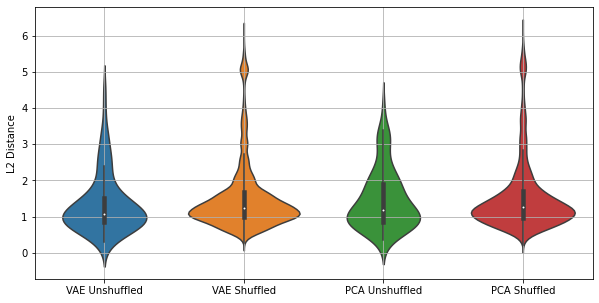

In [40]:
import matplotlib.ticker as plticker

fig, ax = plt.subplots(figsize=(10, 5))
ax = seaborn.violinplot(data = L2_df)
ax.set(ylabel = "L2 Distance")
plt.grid()

plt.show()

In [41]:
L2_df.describe()

,VAE Unshuffled,VAE Shuffled,PCA Unshuffled,PCA Shuffled
count,84.000000,84000.000000,84.000000,84000.000000
mean,1.350408,1.535776,1.471376,1.562905
std,0.817414,0.971850,0.816323,1.015208
min,0.294806,0.263392,0.359248,0.212129
25%,0.848405,0.975436,0.855337,0.963375
50%,1.083596,1.250975,1.170277,1.258401
75%,1.508322,1.675203,1.892191,1.720238
max,4.512147,6.160356,4.043962,6.244653


In [42]:
# computing a 2-tailed 2-sample t-test. In the paper, we compute the one-tailed p-value by dividing the follwing p-value by 2
ttest_ind(L2, L2_random)

Ttest_indResult(statistic=-1.747512789294888, pvalue=0.08055207876828668)